In [41]:
import sys
sys.path.append("../")

import numpy as np
import itertools
from dataclasses import dataclass, field
from typing import Optional
from rl.chapter9.order_book import *
from rl.markov_process import *
from rl.distribution import Choose, Distribution, Gaussian, SampledDistribution, Poisson

In [42]:
@dataclass(frozen=True)
class OrderBookSimulator(MarkovProcess):
    transitions : Dict[str, Distribution]
    num_orders : int
    order_types : List[str]
    order_weights : List[float]

    def transition(self, state: OrderBook) -> Optional[Distribution[OrderBook]]:
        if not state.ascending_asks or not state.descending_bids:
            return None

        next_states = []
        for _ in range(self.num_orders):
            order_type = np.random.choice(self.order_types, p=self.order_weights)
            
            if order_type == 'market-buy':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.buy_market_order(shares=new_shares)

            elif order_type == 'market-sell':
                new_shares = self.transitions['market-shares'].sample()
                _, next_state = state.sell_market_order(shares=new_shares)
            
            elif order_type == 'limit-buy':
                new_price = self.transitions['limit-price'].sample()
                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.buy_limit_order(price=new_price, shares=new_shares)
            
            elif order_type == 'limit-sell':
                new_price = self.transitions['limit-price'].sample()
                new_shares = self.transitions['limit-shares'].sample()
                _, next_state = state.sell_limit_order(price=new_price, shares=new_shares)
        
        return Choose(next_states)

OrderBook(descending_bids=[DollarsAndShares(dollars=66.26, shares=35), DollarsAndShares(dollars=58.68, shares=56), DollarsAndShares(dollars=58.56, shares=111), DollarsAndShares(dollars=52.18, shares=73), DollarsAndShares(dollars=46.71, shares=49)], ascending_asks=[DollarsAndShares(dollars=28.18, shares=44), DollarsAndShares(dollars=41.01, shares=35), DollarsAndShares(dollars=45.5, shares=56), DollarsAndShares(dollars=47.02, shares=92), DollarsAndShares(dollars=53.83, shares=52)])


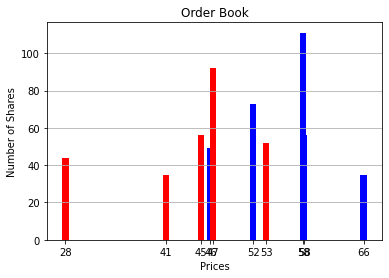

In [43]:
num_asks = 5
num_bids = 5

prices : Sequence[float] = np.abs(np.random.normal(loc=50.0, scale=15, size=num_asks))
shares : Sequence[int] = np.random.randint(10, 120, size=num_asks)

asks_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars)

prices : Sequence[float] = np.abs(np.random.normal(loc=50.0, scale=15, size=num_asks))
shares : Sequence[int] = np.random.randint(10, 120, size=num_asks)

bids_list = sorted([DollarsAndShares(dollars=round(p, 2), shares=s) for p, s in zip(prices, shares)], key=lambda x : x.dollars, reverse=True)



book : OrderBook = OrderBook(descending_bids=bids_list, ascending_asks=asks_list)
print(book)
book.display_order_book()

In [44]:
transitions = {# 'market-shares' : Poisson(20),
               'market-shares' : Gaussian(20, 4).apply(lambda x : Choose(list(x))), 
               'limit-price' : SampledDistribution(sampler=lambda : np.random.uniform(40, 61)), 
               'limit-shares' : SampledDistribution(sampler=lambda : np.random.randint(30, 41))}

simulator = OrderBookSimulator(transitions=transitions, num_orders=10, order_types=['market-buy', 'market-sell', 'limit-buy', 'limit-sell'], order_weights=[0.0, 0.0, 0.5, 0.5])

In [57]:
ob_generator = simulator.simulate(start_state_distribution=Choose([book]))

episodes = [[i for i in itertools.islice(trace, 3)] for trace in itertools.islice(simulator.traces(Choose([book])), 2)]

for e in episodes:
    print(e)
    print()

[OrderBook(descending_bids=[DollarsAndShares(dollars=66.26, shares=35), DollarsAndShares(dollars=58.68, shares=56), DollarsAndShares(dollars=58.56, shares=111), DollarsAndShares(dollars=52.18, shares=73), DollarsAndShares(dollars=46.71, shares=49)], ascending_asks=[DollarsAndShares(dollars=28.18, shares=44), DollarsAndShares(dollars=41.01, shares=35), DollarsAndShares(dollars=45.5, shares=56), DollarsAndShares(dollars=47.02, shares=92), DollarsAndShares(dollars=53.83, shares=52)])]

[OrderBook(descending_bids=[DollarsAndShares(dollars=66.26, shares=35), DollarsAndShares(dollars=58.68, shares=56), DollarsAndShares(dollars=58.56, shares=111), DollarsAndShares(dollars=52.18, shares=73), DollarsAndShares(dollars=46.71, shares=49)], ascending_asks=[DollarsAndShares(dollars=28.18, shares=44), DollarsAndShares(dollars=41.01, shares=35), DollarsAndShares(dollars=45.5, shares=56), DollarsAndShares(dollars=47.02, shares=92), DollarsAndShares(dollars=53.83, shares=52)])]

